<a href="https://colab.research.google.com/github/lamld203844/Biomedical-Image-Processing/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access dataset

In [1]:
# Google colab
from google.colab import drive
drive.mount('/content/drive')

# Kaggle

# Local

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Tree structure of dataset
- us_dataset
    - 20190830T11515
        - image
            -  20190830T115515_9.png
                - ...
        - mask
            -  20190830T115515_9_mask.png
                - ...
        - mask_enhance
            -  20190830T115515_9_mask.png
                - ...
        - frame_label.csv
    - 20190830T115602
    - ...

# About dataset

20190916T104520, 20190916T105526... and other 78 folders are all screenshots extracted from ultrasound videos.
It contains multiple subfolders, and the name of each folder corresponds to the name of the original video.

File structure, for example:
- 20190909T155747 (including all screenshots and corresponding annotations extracted from the video named "20190909T155747")
- image (Screenshot extracted from the video, naming rule: "video name" + "_frame sequence number".png)
- mask (Save the mask of the corresponding image in the image folder, naming rules: "video name" + "_frame number" + "_mask".png)
- mask_enhance (the folder after image processing, red represents SP, green represents Head)
- framelabel.csv (The frame number and corresponding frame label extracted from the video. frame_id is the frame number, frame_label is the frame label)


Note:

https://ps-fh-aop-2023.grand-challenge.org/

1. The images in the image folder have undergone basic preprocessing. After cropping and overwriting operations, the original interface toolbar and text information in the image are removed. The processed size is 1295*1026. In order to prevent information loss, the downsampling process is not performed. At the same time, it has been converted into a grayscale image, which can be directly read in grayscale format when using it.
2. The image in the mask folder may look completely black due to the low label value (pixel value 7-SP, 8-Head).
3. Frame_label frame label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv.

78Video, 6224frame image, 51patients


In [3]:
# Path to dataset
dataset_path = "/content/drive/MyDrive/segmentation/us_data/"

In [4]:
video_num = len(os.listdir(dataset_path))
print(f'There are {video_num} subfolders corresponding to {video_num} videos')

There are 78 subfolders corresponding to 78 videos


In [5]:
# check the number of frame images and mask
img_paths = []
img_mask_paths = []

for vid in os.listdir(dataset_path):
    imgs_path = os.path.join(dataset_path, vid, 'image')
    masks_path = os.path.join(dataset_path, vid, 'mask')

    for filename in os.listdir(imgs_path):
      img_path = os.path.join(imgs_path, filename)
      if os.path.isfile(img_path):
        img_paths.append(img_path)

    for filename in os.listdir(masks_path):
      mask_path = os.path.join(masks_path, filename)
      if os.path.isfile(mask_path):
        img_mask_paths.append(mask_path)

print(f'{len(img_paths)} frame images')
print(f'{len(img_mask_paths)} mask images')

6254 frame images
6247 mask images


**6254 images != 6247 mask >> missing mask**

# Exploration

## Image data
- **Recap**:
  - The images in the image folder have undergone basic preprocessing. After cropping and overwriting operations, the original interface toolbar and text information in the image are removed.
  - The processed size is 1295*1026.
  - In order to prevent information loss, the downsampling process is not performed. At the same time, it has been converted into a grayscale image, which can be directly read in grayscale format when using it.


In [6]:
enumerate(np.random.choice(img_paths, size=1))

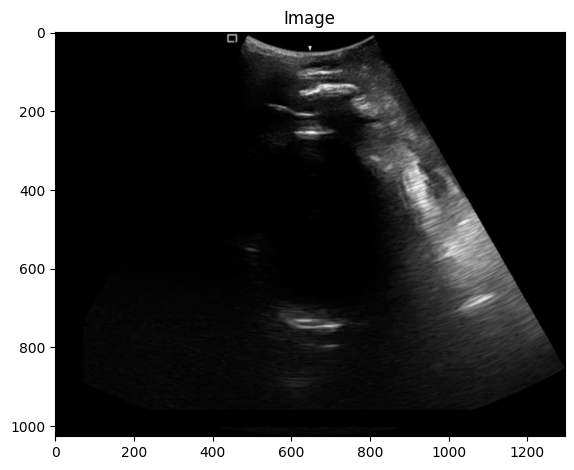

In [7]:
# Randomly choose 1 image
rand_img_path = np.random.choice(img_paths, size=1)[0]
img = plt.imread(rand_img_path)
plt.imshow(img, cmap="gray")
plt.title(f'Image')
plt.tight_layout()
plt.show()

## Mask data:
- The image in the mask folder may look completely black due to the low label value (pixel value 7-SP, 8-Head).

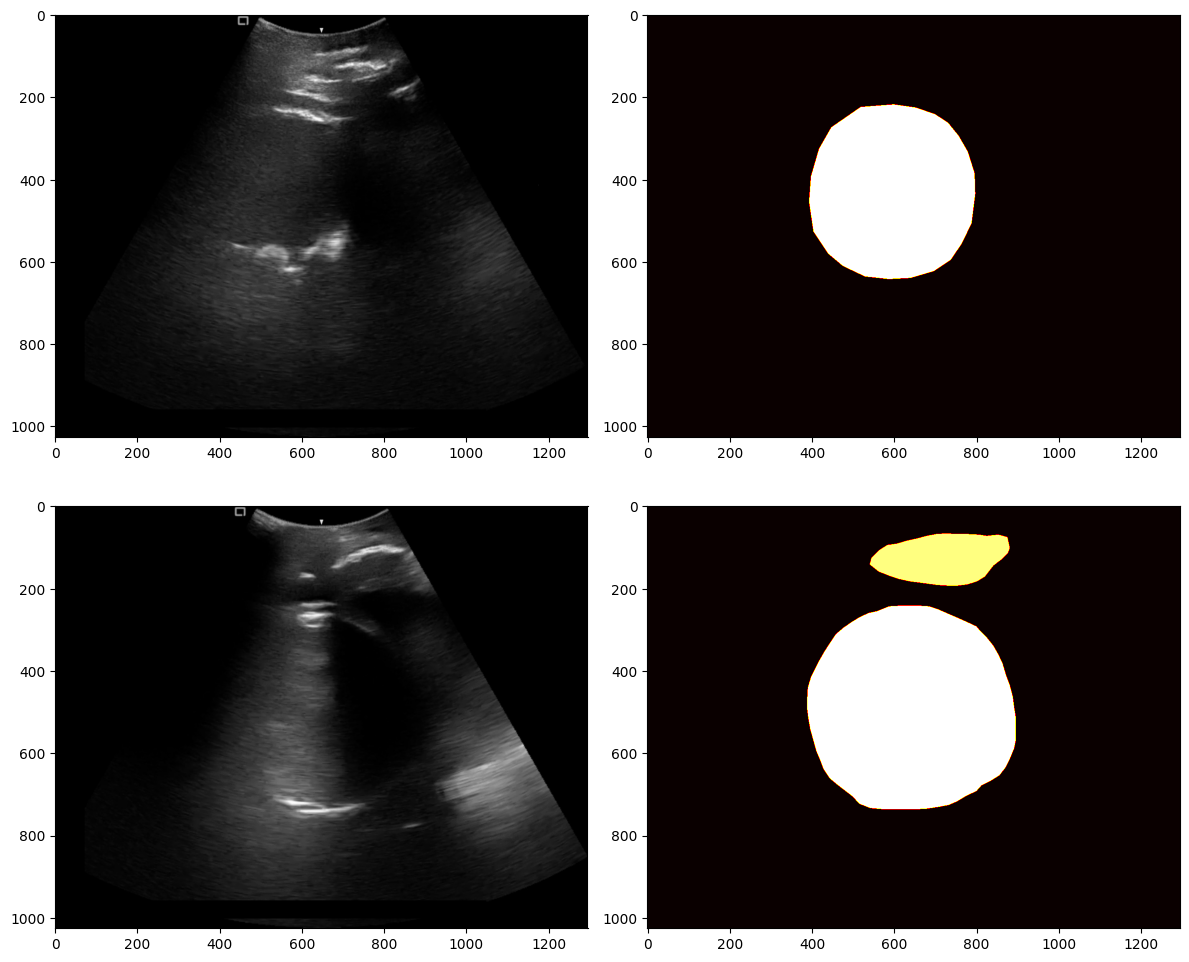

In [9]:
# Visualize random samples with corresponding images
sample_masks = np.random.choice(img_mask_paths, size=2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, mask_path in enumerate(sample_masks):
    mask = plt.imread(mask_path)

    # Find corresponding image file (assuming same naming pattern)
    img_path = mask_path.replace("_mask", "").replace("mask", "image")
    img = plt.imread(img_path)

    axes[i, 0].imshow(img, cmap="gray")

    axes[i, 1].imshow(mask, cmap="hot")

plt.tight_layout()
plt.show()

## Label distribution
- **Recap**: Frame_label frame label 3-None, 4-OnlySP, 5-OnlyHead, 6-SP+Head in framelabel.csv

In [10]:
# Load all frame label files into a single DataFrame
label_dfs = []
for video_dir in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, video_dir, "frame_label.csv")
    if os.path.isfile(label_path):
        # create a tempt df
        df = pd.read_csv(label_path, names=["frame_id", "frame_label"])
        df["video_name"] = video_dir
        label_dfs.append(df)

df = pd.concat(label_dfs, ignore_index=True)
# clean data
df = df[df['frame_id'] != 'frame_id']
df

,frame_id,frame_label,video_name
1,639,5,20190830T115644
2,629,5,20190830T115644
3,619,5,20190830T115644
4,609,5,20190830T115644
5,599,5,20190830T115644
...,...,...,...
6297,679,3,20200103T102728
6298,689,3,20200103T102728
6299,699,3,20200103T102728
6300,709,3,20200103T102728


In [15]:
label_percentages[3]

5.189588688946015

Frame label count:
6    3743
5    1136
3    1022
4     323
Name: frame_label, dtype: int64
Frame label distribution:
6    60.138175
5    18.251928
3    16.420308
4     5.189589
Name: frame_label, dtype: float64


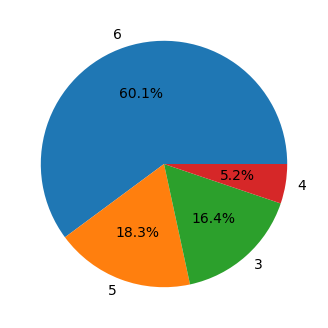

In [17]:
# Analyze frame label distribution across all videos
label_counts = df["frame_label"].value_counts()
label_percentages = (label_counts / len(df)) * 100

print("Frame label count:")
print(label_counts)
print("Frame label distribution:")
print(label_percentages)

# Plot pie chart using seaborn
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels = label_counts.index, autopct='%1.1f%%')
plt.show()

**> Most of label are 6-SP+Head**